# Content
1. [Bài toán](#1)
1. [Mô tả dữ liệu](#2)
1. [Phân tích dữ liệu](#3)
1. [Khởi tạo đặc trưng](#4)
1. [Chuẩn bị dữ liệu train và test](#5)
1. [Huấn luyện](#6)
1. [Kết quả](#7)

<a id=""></a> <br>
# 1. Bài toán


<p style="font-size:18px"> Dự báo động đất là một trong những vấn đề quan trọng của khoa học vì những hậu quả tàn khốc của chúng. Những nghiên cứu hiện nay về vấn đề này sẽ thường tập trung vào ba câu hỏi: Khi nào ?, Ở đâu ? và Quy mô như thế nào ? </p>
<p style="font-size:18px"> Trong bài toán này, mục tiêu của ta là đi dự đoán khi nào động đất sẽ xảy ra. Cụ thể là dự đoán thời gian còn lại trước khi các trận động đất trong phòng thí nghiệm xảy ra từ dữ liệu địa chấn theo thời gian thực. Đây là một bài toán hết sức thực tế, vì nếu dự báo được càng sớm, càng chính xác thì ta sẽ có được những cảnh báo để giảm thiểu rủi ro. </p>


<a id="2"></a> <br>
# 2. Mô tả dữ liệu


<p style="font-size:18px">
Dữ liệu được sử dụng cho việc đào tạo mô hình gồm 2 cột:</p>

    
1. `Acoustic_data`: <p style="font-size:18px">là dữ liệu địa chấn (cường độ sóng thu được từ lòng đất) được mô tả dưới dạng kiểu số nguyên [int16] </p>
2. `time_to_failure`: <p style="font-size:18px">là thời gian mà trận động đất tiếp theo sẽ xảy ra trong phòng thí nghiệm (tính bằng giây) được mô tả dưới kiểu số thực [float64] </p>



`train.csv`: <p style="font-size:18px"> Trong mỗi lần thử nghiệm, dữ liệu địa chấn được và thời gian còn lại trước khi động đất xảy ra được đo trong 0.0375s với tần số ở 4MHz do đó sẽ có 150000 điểm dữ liệu cho mỗi phân đoạn đo (từ đây em sẽ gọi là 1 <i>segment</i> để không làm phức tạp ý đọc). File train là tập hợp gồm 629145480 tương đương với hơn 4194 segments.</p>

<p style="font-size:18px">
    
`test`:
<p style="font-size:18px">
Là một folder gồm nhiều file nhỏ, mỗi file sẽ là dữ liệu địa chấn của 1 segment (gồm 150000 điểm dữ liệu) </p>

`sample_submission.csv`:
<p style="font-size:18px">
Là mẫu file submit của cuộc thi </p>

## 2.1. Đọc dữ liệu 

<p style="font-size:18px"> Đầu tiên ta cần import những tư viện sẽ sử dụng trong notebook này</p>

In [ ]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

<p style="font-size:18px"> Cài đặt các đường dẫn đến bộ dữ liệu</p>

In [ ]:
test_path = '../input/LANL-Earthquake-Prediction/test'
submission_path = '../input/LANL-Earthquake-Prediction/sample_submission.csv'
train_path = '../input/LANL-Earthquake-Prediction/train.csv'

## 2.2. Biểu diễn file train

<p style="font-size:18px"> Do file train khá nặng (9.7GB) nên thời gian đọc lâu và tốn nhiều RAM. Em sử dụng bộ thư viện Pandas để hỗ trợ đọc ghi file CSV, train_df sau khi chạy xong kết quả sẽ là một data frame</p>

In [ ]:
%%time
train_df = pd.read_csv(train_path,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

<p style="font-size:18px"> 5 dòng đầu tiên của file train </p>

In [ ]:
train_df.head()

<p style="font-size:18px"> Kích cỡ của train_df. Bộ dữ liệu có hơn 600 triệu dòng và 2 cột. Đây là những dữ liệu thô thu thập được từ các máy trong phòng thí nghiệm. Em sẽ cần bước tạo ra các feature từ bộ dữ liệu này để làm dữ liệu huấn luyện mô hình </p>

In [ ]:
train_df.shape

<p style="font-size:18px"> Do pandas không thể hiện toàn bộ các chữ số sau dấu phẩy, nên ta sẽ xem đến 10 chữ số sau dấu phẩy bằng cách làm tròn như sau để thấy được sự thay đổi của thời gian </p>


In [ ]:
pd.options.display.precision = 11
train_df.head()

### Nhận xét qua về train_df
* <p style="font-size:18px"> train_df là data frame có lượng dữ liệu rất lớn nhưng lại chỉ là dữ liệu thô lấy từ thực nghiệm. </p>
* <p style="font-size:18px"> Thời gian <b>time_to_failure</b> giảm dần trong mỗi segment.  </p>


## 2.3. Biểu diễn file test

<p style="font-size:18px"> Ta có thể thấy 1 file test sẽ gồm 150000 hàng tương ứng với 1 phân đoạn thử nghiệm, nhiệm vụ của ta là dự đoán 150000 mốc thời gian <b>time_to_failure</b> cho mỗi điểm dữ liệu đó </p>


In [ ]:
sample_test_df = pd.read_csv(test_path + "/seg_00030f.csv")
sample_test_df

<a id="3"></a> <br>
# 3. Phân tích dữ liệu 

## 3.1. Xu hướng của acoustic_data và time_to_failure trong 1% dữ liệu
<p style="font-size:18px"> Để xem được xu hướng, đồ thị biểu diễn của dữ liệu, em sử dụng bộ thư viện <b>matplotlib</b>. Đây là bộ thư viện hỗ trợ vẽ biểu đồ dữ liệu </p> 
<p style="font-size:18px"> Ở đây em vẽ đồng thời 2 loại dữ liệu <i>acoustic_data</i> và <i>time_to_failure</i> trong cùng một đồ thị để có thể nhìn thấy được sự tương quan với nhau </p>
<p style="font-size:18px"> values[::100] là slice, nghĩa là em sẽ lấy các giá trị cách nhau 100 bước nhảy, bắt đầu từ giá trị 0. Việc này nhằm đảm bảo lấy được 1% dữ liệu, đồng thời cũng tạo được sự bao quát toàn bộ dữ liệu thay vì việc lấy 6 triệu dữ liệu đầu tiên</p>

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 8))

plt.title("Xu hướng của acoustic_data và time_to_failure trong 1% dữ liệu (mỗi điểm cách nhau 100 bước nhảy)")
plt.plot(train_df.acoustic_data.values[::100], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])

ax2 = ax1.twinx()
plt.plot(train_df.time_to_failure.values[::100], color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))


### Nhận xét
<p style="font-size:18px"> Ta có thể thấy mỗi khi <b>time_to_failure</b> trở về 0 đồng nghĩa với xảy ra động đất thì giá trị <b>acoustic_data</b> cũng có sự thay đổi lớn ngay trước đó. <br>Một điểm đặc biệt nữa, khi nhìn vào biểu đồ 1% data này (sẽ lấy các giá trị cách nhau 100 bước nhảy) thì ta có thể phán đoán rằng bộ dữ liệu train có 16 lần xảy ra động đất. </p>


## 3.2. Xu hướng của time_to_failure và acoustic_data trong 7.5 triệu dòng dữ liệu (~50 segment) đầu tiên 
<p style="font-size:18px"> Dựa theo biểu đồ trên, em ước lượng được trong khoảng 10tr dữ liệu đầu sẽ có 1 lần xảy ra động đất. Do đó em sẽ quan sát 7.5 triệu dòng dữ liệu đầu tiền (tương đương với 50 segment). </p>
<p style="font-size:18px"> 2 đồ thị dưới đây sẽ có cùng khoảng giá trị theo trục x. Nghĩa là tại 1 vị trí ở <b>time_to_failure</b>, ta gióng xuống đồ thị dưới sẽ được giá trị <b>acoustic_data</b> tương ứng. </p>

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(train_df.index.values[:7500000], train_df.time_to_failure.values[:7500000], c="red")
ax[0].set_title("Đồ thị của time_to_failure trong 7.5 triệu hàng đầu tiên")
ax[0].set_ylabel("time_to_failure (ms)")

ax[1].plot(train_df.index.values[:7500000], train_df.acoustic_data.values[:7500000], c="green")
ax[1].set_title("Đồ thị của acoustic_data trong 7.5 triệu hàng đầu tiên")
ax[1].set_ylabel("acoustic_data")

### Nhận xét

<p style="font-size:18px"> Quan sát trong 2 biểu đồ trên ta có thể thấy, trước khi trận động đất xảy ra (là khoảng thời gian <b>time_to_failure</b> đạt 0) thì sẽ có những thay đổi lớn trước đó ở giá trị địa chấn <b>acoustic_data</b> và sau đó là một khoảng thời gian ít biến động hơn bình thường </p>


## 3.3. Phân tích time_to_failure trong 150000 giá trị đầu

<p style="font-size:18px"> Vậy giờ ta cùng xem thử trong 150000 điểm dữ liệu đầu (1 segment), xu hướng của <strong>time_to_failure</strong> diễn ra như thế nào </p>

In [ ]:
plt.subplots(figsize=(25,8))

plt.plot(train_df.index.values[:150000], train_df.time_to_failure.values[:150000], c="red")
plt.ylabel("Time_to_failure (ms)")
plt.title("Sự thay đổi của time_to_failure trong 150000 điểm dữ liệu đầu")
plt.show()

### Nhận xét
<p style="font-size:18px"> Giá trị của <strong>time_to_failure</strong> có xu hướng giảm dần theo từng bậc thang, liệu những bước giảm đó có đều nhau và những đường ngang có thật sự là không thay đổi giá trị ? </p>
<p style="font-size:18px"> Em sẽ làm rõ vấn đề này bằng cách vẽ ra biểu đồ thể hiện sự chênh lệch giữa các giá trị <b>time_to_failure</b> liền nhau và xu hướng biến động của 1 đường ngang đầu tiên. </p>

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(25,10))

ax[0].plot(train_df.index.values[0:149999], np.diff(train_df.time_to_failure.values[0:150000]), c="r")
ax[0].set_ylabel("Độ lớn các bước giảm")
ax[0].set_title("Chênh lệch độ lớn giữa các giá trị time_to_failure");

ax[1].plot(train_df.index.values[0:4000], train_df.time_to_failure.values[0:4000], c="r")
ax[1].set_ylabel("time_to_failure (ms)")
ax[1].set_title("Xu hướng của time_to_failure trong một đường ngang");

### Nhận xét
<p style="font-size:18px"> Qua 2 biểu đồ trên ta có thể thấy, những bước nhảy trong biểu đồ <b><i>"Sự thay đổi của time_to_failure trong 150000 điểm dữ liệu đầu"</i></b> là <strong>không đều nhau</strong>. <br> Đồng thời, giá trị của time_to_failure trên từng đường ngang có xu hướng <strong>giảm tuyến tính</strong> </p>


## 3.4. Mật độ của acoustic_data trong 7500000 giá trị đầu

<p style="font-size:18px"> Em tạo ra 1 data frame gồm 7.5 triệu dòng dữ liệu đầu tiên để quan sát được mật độ cũng như mô tả của nó bằng hàm describe() được cung cấp bởi pandas </p>


In [ ]:
train_7m5 = train_df[:7500000]
train_7m5.describe()

<p style="font-size:18px"> Biểu đồ dưới đây thể hiện mật độ phân bố của các dữ liệu trong train_7m5 </p>


In [ ]:
train_7m5['acoustic_data'].hist(bins=30, range = [-15,15], align='mid')
plt.title("Mật độ của acoustic_data trong 7500000 giá trị đầu")
plt.xlabel('acoustic data')
plt.ylabel('examples')
plt.show()

### Nhận xét
<p style="font-size:18px"> Trong 7.5 triệu điểm dữ liệu đầu, giá trị <b>acoustic_data</b> phần lớn tập trung tại khoảng 0-10. <br>Đây có thể là cơ sở để ta drop đi những giá trị nhiễu </p>


## 3.5. Mô tả một vài file dữ liệu test

In [ ]:
nameOfFileTest = ['seg_0012b5.csv', 'seg_00030f.csv', 'seg_00184e.csv']
for name in nameOfFileTest:
    plt.subplots(figsize=(16, 8))
    seg = pd.read_csv(test_path  + '/' + name)
    plt.plot(seg.acoustic_data.values, c="green")
    plt.ylabel("acoustic_data")
    plt.title("Test " + name);
    plt.show()


## Nhận xét:
<p style="font-size:18px"> Mỗi file test là một segment gồm 150000 điểm dữ liệu. Ta có thể dự đoán trong mỗi file test trong 3 file trên đều có xảy ra động đất do có một sự thay đổi giá trị mạnh bất thường tại 1 điểm </p>

<a id="4"></a> <br>
# 4. Khởi tạo đặc trưng

<p style="font-size:18px"> Do lượng data quá lớn (hơn 600 triệu dòng), vậy nên em chia nhỏ data thành các segments với size là 150000 dòng dữ liệu. Điều này cũng phù hợp khi huấn luyện và dự đoán vì độ lớn của một file test cũng là 150000 dòng.</p>

In [ ]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Số lượng segments là: ", segments)

<p style="font-size:18px"> Khởi tạo giá trị X_train và y_train. Trong đó số lượng index là số lượng segments, y_train có 1 cột dữ liệu là <i>time_to_failure</i> còn đặc trưng của X_train sẽ được khởi tạo sau </p>

In [ ]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

### Nhận xét
<p style="font-size:18px"> Dữ liệu <b>acoustic_data</b> là dữ liệu thô thu thập được từ máy đo sóng địa chất từ lòng đất, do đó ta không thể sử dụng nó như một đặc trưng để huấn luyện mô hình. Vì vậy, em tạo ra các đặc trưng từ dữ liệu thô đó và xem xét lựa chọn đặc trưng sử dụng cho việc huấn luyện mô hình. </p>
<p style="font-size:18px"> Các đặc trưng em khởi tạo bao gồm những đặc trưng cơ bản như mean, std, max, min, sum, quantile,.. của mỗi cả segment hoặc của 10000, 50000 giá trị. </p>
<p style="font-size:18px"> Ngoài ra còn có đặc trưng do biến đổi từ miền thời gian về miền tần số bằng <b>FFT (Fast Fourier Transform)</b> </p>

In [ ]:
xc = pd.Series(seg['acoustic_data'].values)
def feature_generate(df, x, seg):
    df.loc[seg, 'ave'] = x.mean() 
    df.loc[seg, 'std'] = x.std()  
    df.loc[seg, 'max'] = x.max()
    df.loc[seg, 'min'] = x.min()
    df.loc[seg, 'sum'] = x.sum()
    df.loc[seg, 'mad'] = x.mad()
    df.loc[seg, 'skew'] = x.skew()
    
    df.loc[seg, 'abs_min'] = np.abs(x).min()
    df.loc[seg, 'abs_max'] = np.abs(x).max()
    df.loc[seg, 'abs_mean'] = np.abs(x).mean()
    df.loc[seg, 'abs_std'] = np.abs(x).std()
    
    df.loc[seg, 'q01'] = np.quantile(x,0.01)
    df.loc[seg, 'q05'] = np.quantile(x,0.05)
    df.loc[seg, 'q95'] = np.quantile(x,0.95)
    df.loc[seg, 'q99'] = np.quantile(x,0.99)
    
    df.loc[seg, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    df.loc[seg, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    df.loc[seg, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    df.loc[seg, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    
    df.loc[seg, 'average_first_10000'] = x[:10000].mean()
    df.loc[seg, 'average_last_10000']  =  x[-10000:].mean()
    df.loc[seg, 'average_first_50000'] = x[:50000].mean()
    df.loc[seg, 'average_last_50000'] = x[-50000:].mean()
    
    df.loc[seg, 'std_first_10000'] = x[:10000].std()
    df.loc[seg, 'std_last_10000']  =  x[-10000:].std()
    df.loc[seg, 'std_first_50000'] = x[:50000].std()
    df.loc[seg, 'std_last_50000']  =  x[-50000:].std()
    
    df.loc[seg, 'std_first_10000'] = x[:10000].min()
    df.loc[seg, 'std_last_10000']  =  x[-10000:].min()
    df.loc[seg, 'std_first_50000'] = x[:50000].min()
    df.loc[seg, 'std_last_50000']  =  x[-50000:].min()
    
    df.loc[seg, 'std_first_10000'] = x[:10000].max()
    df.loc[seg, 'std_last_10000']  =  x[-10000:].max()
    df.loc[seg, 'std_first_50000'] = x[:50000].max()
    df.loc[seg, 'std_last_50000']  =  x[-50000:].max()
    
    df.loc[seg, '10q'] = np.percentile(x, 0.10)
    df.loc[seg, '25q'] = np.percentile(x, 0.25)
    df.loc[seg, '50q'] = np.percentile(x, 0.50)
    df.loc[seg, '75q'] = np.percentile(x, 0.75)
    df.loc[seg, '90q'] = np.percentile(x, 0.90)
    
    zc = np.fft.fft(xc)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    df.loc[seg, 'Rmean'] = realFFT.mean()
    df.loc[seg, 'Rstd'] = realFFT.std()
    df.loc[seg, 'Rmax'] = realFFT.max()
    df.loc[seg, 'Rmin'] = realFFT.min()
    df.loc[seg, 'Imean'] = imagFFT.mean()
    df.loc[seg, 'Istd'] = imagFFT.std()
    df.loc[seg, 'Imax'] = imagFFT.max()
    df.loc[seg, 'Imin'] = imagFFT.min()
    df.loc[seg, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    df.loc[seg, 'Rstd__last_5000'] = realFFT[-5000:].std()
    df.loc[seg, 'Rmax_last_5000'] = realFFT[-5000:].max()
    df.loc[seg, 'Rmin_last_5000'] = realFFT[-5000:].min()
    df.loc[seg, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    df.loc[seg, 'Rstd_last_15000'] = realFFT[-15000:].std()
    df.loc[seg, 'Rmax_last_15000'] = realFFT[-15000:].max()
    df.loc[seg, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    for w in [10, 100, 1000, 10000]:
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_min = x.rolling(w).min().dropna().values
        x_roll_max = x.rolling(w).max().dropna().values
        
        df.loc[seg, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        df.loc[seg, 'std_roll_std_' + str(w)] = x_roll_std.std()
        df.loc[seg, 'max_roll_std_' + str(w)] = x_roll_std.max()
        df.loc[seg, 'min_roll_std_' + str(w)] = x_roll_std.min()
        df.loc[seg, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        df.loc[seg, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        df.loc[seg, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        df.loc[seg, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        df.loc[seg, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        df.loc[seg, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        df.loc[seg, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        df.loc[seg, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        df.loc[seg, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        df.loc[seg, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        df.loc[seg, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        
        df.loc[seg, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        df.loc[seg, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        df.loc[seg, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        df.loc[seg, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        
        df.loc[seg, 'std_roll_min_' + str(w)] = x_roll_min.std()
        df.loc[seg, 'max_roll_min_' + str(w)] = x_roll_min.max()
        df.loc[seg, 'q05_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.05)
        df.loc[seg, 'q95_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.95)

        df.loc[seg, 'std_roll_max_' + str(w)] = x_roll_max.std()
        df.loc[seg, 'min_roll_max_' + str(w)] = x_roll_max.min()
        df.loc[seg, 'q05_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.05)
        df.loc[seg, 'q95_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.95)
    return df

<p style="font-size:18px"> Ta cùng tạo ra các đặc trưng cho X_train bằng cách truyền lần lượt các segment vào hàm feature_generate vừa tạo ở trên. </p>

In [ ]:
for s in range(segments):
    seg = train_df.iloc[s*150000:s*150000+150000]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    y_train.loc[s, 'time_to_failure'] = y
    X_train = feature_generate(X_train,x,s)

<p style="font-size:18px"> Cùng xem lại X_train sau khi đã được khởi tạo thêm các đặc trưng </p>

In [ ]:
X_train

<p style="font-size:18px"> Mô tả sơ lược về X_train. Sau khi xem qua, nếu hàng hay cột nào thiếu data hoặc data không dùng được ta sẽ drop đi để tránh gây nhiễu mô hình </p>

In [ ]:
X_train.describe()

<p style="font-size:18px"> Sau khi tạo xong X_train, y_train, ta cùng xem độ tương quan giữa 2 tập này. Dưới đây là hàm plot_feature, để mô tả sự tưởng quan của từng feature của X so với y_train. Đặc trưng nào không phù hợp ta sẽ loại bỏ </p>

In [ ]:
def plot_feature(feature, X=X_train):
    fig, ax = plt.subplots(figsize=(20, 8)) 
    ax.set_xlabel(feature)
    ax.set_ylabel('time_to_failure')
    plt.title('{} - time_to_falure correlation'.format(feature), color='r')
    plt.scatter(x = X[feature], y = y_train)

<p style="font-size:18px"> Vẽ biểu đồ mô tả sự tương quan giữa các đặc trưng của X_train so với y_train </p>

In [ ]:
for feature in X_train.columns:
    plot_feature(feature)

<a id="5"></a> <br>
# 5. Chuẩn bị dữ liệu train và test

## 5.1. Dữ liệu để train

### Nhận xét:
<p style="font-size:18px"> Qua những gì được biểu diễn trên đồ thị, có 2 đồ thị của <b>abs_min</b> và <b>abs_q01</b> là chỉ toàn giá trị 0 nên ta sẽ loại bỏ 2 đặc trưng này. </p>
<p style="font-size:18px"> Ngoài ra còn có các đặc trưng mà đồ thị tương quan không thể hiện được thông tin gì (không phải linear cũng không phải non-linear) nên em cũng bỏ những đặc trưng này để tránh làm nhiễu dữ liệu.  </p>

In [ ]:

X_train = X_train.drop(columns=['abs_min', 'abs_q01', 'q05_roll_abs_mean_10000', 'q95_roll_mean_10000', 'q05_roll_mean_10000', 'ave_roll_mean_10000','q05_roll_abs_mean_1000', 
                                'ave_roll_mean_1000', 'q05_roll_abs_mean_100', 'ave_roll_mean_100', 'min_roll_std_100', 'ave_roll_mean_10', 
                                'average_first_50000', 'average_last_50000', 'average_first_10000', 'average_last_10000', 'sum', 'ave'])

<p style="font-size:18px"> X_train sau khi bỏ các đặc trưng nhiễu còn lại 138 đặc trưng và 4194 hàng tương ứng 4194 segment. </p>

In [ ]:
X_train

### Nhận xét
<p style="font-size:18px"> Do các đặc trưng đang được biểu diễn bởi những miền giá trị khác nhau, vì vậy em sẽ chuẩn hoá chúng về cùng 1 miền giá trị. Việc các dữ liệu huấn luyện và test thuộc cùng một miền giá trị sẽ tốt hơn cho mô hình trong việc học cũng như việc dự đoán.</p>
<p style="font-size:18px"> Em sử dụng thư viện <b>Standard Scaler</b> để giải quyết vấn đề này </p>

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

<p style="font-size:18px"> Đây là X_train sau khi đã được chuẩn hoá.  </p>

In [ ]:
scaled_X_train

## 5.2. Dữ liệu để test

<p style="font-size:18px"> Đây là dữ liệu ở folder test dùng để submit cho bài toán. Dữ liệu để validate cho mô hình em sẽ chia khi huấn luyện bằng KFold </p>
<p style="font-size:18px"> Đọc file submission và tạo X_test có cấu trúc bằng số cột của X_train. Còn số hàng sẽ ứng với số file test. <br>
    Mỗi một file test em sẽ coi là 1 hàng của X_test và lại tạo feature từ 150000 điểm dữ liệu như cách làm với X_train rồi thêm hàng đó vào X_test </p>

In [ ]:
submission = pd.read_csv(submission_path, index_col='seg_id')
X_test = pd.DataFrame(columns=scaled_X_train.columns, dtype=np.float64, index=submission.index)
for s in X_test.index:
    seg = pd.read_csv(test_path + '/' + s + '.csv')
    x = pd.Series(seg['acoustic_data'].values)
    X_test = feature_generate(X_test,x,s)

<p style="font-size:18px"> Em cũng sẽ bỏ đi những đặc trưng không dùng được như X_train </p>

In [ ]:
X_test = X_test.drop(columns=['abs_min', 'abs_q01', 'q05_roll_abs_mean_10000', 'q95_roll_mean_10000', 'q05_roll_mean_10000', 'ave_roll_mean_10000','q05_roll_abs_mean_1000', 
                                'ave_roll_mean_1000', 'q05_roll_abs_mean_100', 'ave_roll_mean_100', 'min_roll_std_100', 'ave_roll_mean_10', 
                                'average_first_50000', 'average_last_50000', 'average_first_10000', 'average_last_10000', 'sum', 'ave'])

<p style="font-size:18px"> Biểu diễn X_test </p>

In [ ]:
X_test

<p style="font-size:18px"> Giống như với X_train, em cũng sẽ chuẩn hoá các giá trị của X_test về cùng một miền giá trị bằng Standard Scaler </p>

In [ ]:
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

<p style="font-size:18px"> X_test sau khi được chuẩn hoá </p>

In [ ]:
scaled_X_test

<a id="6"></a> <br>
# 6.Huấn luyện 


## 6.1. Chuẩn bị

<p style="font-size:18px"> Về huấn luyện mô hình, em đã thử với 2 mô hình là <b>SVR</b> và <b>LightGBM</b>. </p>
<p style="font-size:18px"> Do ban đầu kết quả của SVR chưa được tốt nên em có tìm hiểu các thuật toán khác để cải thiện kết quả. Và sau cùng em lựa chọn LightGBM. </p>
<br>
<p style="font-size:18px">Trong mỗi mô hình em đều sử dụng <b>K-Fold cross validation</b>. K-Fold sẽ chia bộ dữ liệu của ta ra thành k folds, mỗi fold sẽ đều được thay phiên làm tập test một lần và các folds còn lại làm tập train. Từ đó sẽ giúp đánh giá mô hình được chính xác hơn từ nhiều góc nhìn. </p>
<p style="font-size:18px">Ngoài ra, bài toán còn giới thiệu một hàm lỗi là <b>mean_absoluted_error</b> với công thức như sau: </p>

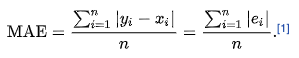

<p style="font-size:18px">Do đây là cách tính hàm lỗi để tính điểm khi submit của bài toán nên em sẽ dùng luôn trong bài làm của mình. </p>


## 6.2. Mô hình SVR

### Lý thuyết:
<p style="font-size:18px"> SVR (Support Vector Regression) là một mô hình hồi quy nhưng lại sử dụng thuật toán SVM (Support Vector Machine - thuật toán phân loại) để dự đoán giá trị của một biến liên tục. Ý tưởng cơ bản của SVR là ánh xạ không gian đầu vào sang một không gian đặc trưng nhiều chiều để ta có thể áp dụng được hồi quy tuyến tính. Để xây dựng được hàm hồi quy này thì ta không cần sử dụng hết toàn bộ các điểm trong bộ dữ liệu, nên những điểm nào có đóng góp vào việc xây dựng hàm hồi quy sẽ được gọi là Support Vector, và việc dự đoán giá trị hay phân lớp cũng chỉ phụ thuộc vào các Support Vector đó. </p>

<p style="font-size:18px"> Hàm hồi quy cần tìm có dạng: </p> 

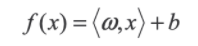

<p style="font-size:18px"> Trong đó: w là vector trọng số, x là vector đầu vào. Mục tiêu huấn luyện SVR là tìm ra được giá trị w và b. Để làm được điều đó, SVR đã sử dụng hàm lỗi ε-insensitive. Đặc điểm của hàm lỗi này là nếu sự sai lệch giữa giá trị dự đoán và giá trị đích nhỏ hơn ε (ε > 0) thì sẽ coi như độ sai lệch lỗi bằng 0. Mục tiêu sẽ đi tối ưu hàm mất mát mà vẫn thỏa mãn điều kiện sau: </p>

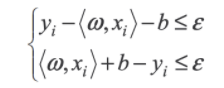

<p style="font-size:18px"> Tuy nhiên, bộ dữ liệu sẽ thường có những điểm gây nhiễu, không có cách nào có thể đáp ứng tất cả các điểm trong bộ dữ liệu đó. Ví dụ có những điểm dữ liệu sẽ không bao giờ thỏa mãn, nằm trong khoảng ε của ta. Một ý tưởng được nảy ra để giải quyết vấn đề này là ta thêm một biến lỏng ξ (slack variable) với mục đích chấp nhận những điểm nhiễu kia đúng và vẫn đảm bảo được sự đúng đắn của mô hình. Khi đó, ta cần đi tối ưu hàm mất mát với điều kiện bài toán như sau </p>

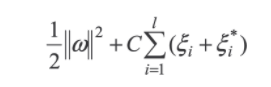

<p style="font-size:14px"> <b>Hình 4.3:</b> Hàm mất mát - Nguồn: bài báo “Support Vector Regression”</p>

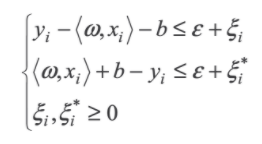

<p style="font-size:14px"> <b>Hình 4.4:</b> Điều kiện bài toán - Nguồn: bài báo “Support Vector Regression” </p>




### Cài đặt cụ thể:
<p style="font-size:18px"> Để cài đặc được mô hình SVR, em đã sử dụng bộ công cụ <b>scikit-learn</b> để gọi hàm SVR. </p>
<p style="font-size:18px">Do bộ dữ liệu quá lớn, khi fine tuning bằng <b>GridSearchCV</b> em đã bị tràn RAM nên em quyết định thử params bằng tay dựa trên kinh nghiệm cá nhân. </p>

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import re
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
scaled_X_train = scaled_X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

predictions_svr = np.zeros(len(scaled_X_test))

for fold_, (train_idx, val_idx) in enumerate(folds.split(scaled_X_train,y_train.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_X_train.iloc[train_idx], scaled_X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
    
    model.fit(X_tr, y_tr)
    
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    print("MAE: ", mae)
    predictions_svr += model.predict(scaled_X_test) / folds.n_splits

## 6.3. Mô hình LightGBM

### Lý thuyết:
<p style="font-size:18px"> LightGBM là một framework được Microsoft phát triển mục đích xử lý thuật toán <b>Gradient boosting</b>. Ưu điểm của LightGBM so với các framework khác như XgBoost hay pGBRT là LightGBM sử dụng hai kĩ thuật mới <b>Gradient-based One-Side Sampling (GOSS)</b> và <b>Exclusive Feature Bundling (EFB)</b>. Nhờ đó mà cải thiện được tốc độ tính toán cũng như độ chính xác. Đặc biệt là ở những bộ dữ liệu lớn</p>
<p style="font-size:18px"> <b>Gradient-based One-Side Sampling (GOSS)</b> sẽ lấy những data instance có gradient lớn và chọn ngẫu nhiên x% trong số những data instance có gradient nhỏ để đưa vào làm dữ liệu huấn luyện. Giải thích cho điều này là bởi, những data có gradient lớn theo định nghĩa về mức tăng thông tin thì sẽ mang lại nhiều thông tin hơn. Do đó GOSS ưu tiên giữ lại những data có gradient lớn </p>
<p style="font-size:18px"> <b>Exclusive Feature Bundling (EFB)</b> giúp cải thiện tốc độ huấn luyện của LightGBM bằng cách down sample chiều dữ liệu. Những feature không đồng thời bằng 0, EFB sẽ chuẩn hoá về thành 1 feature duy nhất để giảm chiều dữ liệu, từ đó tốc độ huấn luyện được cải thiện. </p>


### Cài đặt
<p style="font-size:18px"> Đối với mô hình này, em cũng cài đặt bằng bộ công cụ scikit_learn. Với tập params thu thập được và thử bằng tay. Tuy nhiên dù có thay đổi params thì kết quả thay đổi không đáng kể. </p>


In [ ]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}

In [ ]:
from sklearn.model_selection import KFold
import re
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
scaled_X_train = scaled_X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

oof = np.zeros(len(scaled_X_train))
predictions = np.zeros(len(scaled_X_test))

for fold_, (train_idx, val_idx) in enumerate(folds.split(scaled_X_train,y_train.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_X_train.iloc[train_idx], scaled_X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 10000, n_jobs = -1)
    
    model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',verbose=1000, early_stopping_rounds=500)
    
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    predictions += model.predict(scaled_X_test, num_iteration=model.best_iteration_) / folds.n_splits

## Nhận xét:
<p style="font-size:18px">Ta có thể thấy MAE của mô hình SVR có phần thấp hơn so với LightGBM, tuy nhiên, kết quả sau khi submit lại trái ngược. Kết quả của LightGBM cao vượt trội hơn so với SVR. Em phán đoán rằng mô hình SVR có thể đã bị overfitting với bộ dữ liệu huấn luyện, hoặc bộ dữ liệu submit có nhiều điểm gây nhiễu nằm ngoài ống hơn khiến cho mô hình SVR không còn được chính xác </p>


In [ ]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)

In [ ]:
submission.time_to_failure = predictions_svr
submission.to_csv('submission_svr.csv',index=True)

<a id="7"></a> <br>
# 7. Kết quả

## 7.1. LightBGM

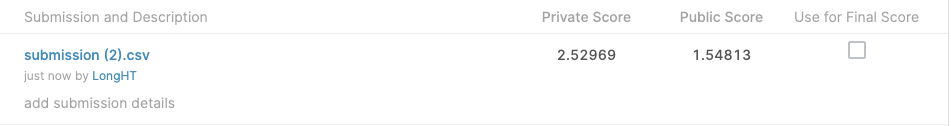

## 7.2. SVR

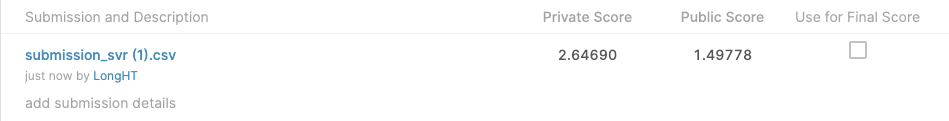